# Supplementary Report: Cross-Validation

This is a **supporting notebook** for the final project for the Summer 2024 session of Intro to Data-Centric Computing. This report is focused on cross-validation of the models found in the main notebook, which can be found in the zipped submission folder.

This document is mostly a practice notebook; it does not contain any significant discussion text, as most of the discussion has already been carried out in the main report.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
df = pd.read_csv('cyclone_model_runs.csv')

In [3]:
df_copy = df.copy()

df_copy['pressure_shift'] = df_copy.pressure + 150
df_copy['log_pressure'] = np.log(df_copy.pressure_shift)

df_copy['bin_mass'] = np.where(df_copy.mass > df_copy.mass.median(), 1, 0)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


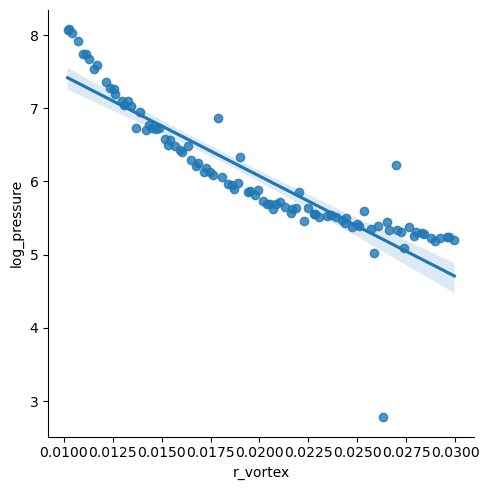

In [7]:
sns.lmplot(data = df_copy, x='r_vortex', y='log_pressure')
plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


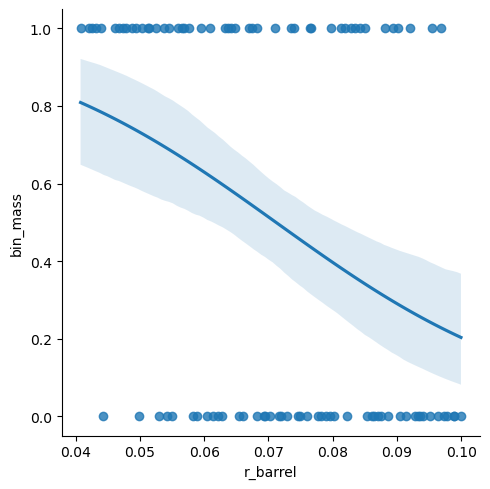

In [8]:
sns.lmplot(data = df_copy, x='r_barrel', y='bin_mass', logistic=True)
plt.show()

## split data

In [10]:
df_pressure = df_copy[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet', 'log_pressure']].copy()

In [11]:
df_mass = df_copy[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet', 'bin_mass']].copy()

## set up kfold generators

In [9]:
from sklearn.model_selection import KFold # for regression
from sklearn.model_selection import StratifiedKFold # for classification

In [12]:
df_pressure_inputs = df_pressure.drop(columns=['log_pressure']).copy()

In [13]:
# kfold functions like numpy inputs
df_pressure_inputs.to_numpy().shape

(96, 5)

In [14]:
# do the output too
df_pressure.log_pressure.to_numpy().shape

(96,)

In [15]:
# for regression
kf_a = KFold(n_splits=5, shuffle=True, random_state=101)

In [17]:
kf_a.split(df_pressure_inputs.to_numpy())

<generator object _BaseKFold.split at 0x7f91149e4820>

In [18]:
for train_id, test_id in kf_a.split(df_pressure_inputs.to_numpy()):
    print('The training set has %d rows while the test set has %d rows' % (train_id.size, test_id.size))

The training set has 76 rows while the test set has 20 rows
The training set has 77 rows while the test set has 19 rows
The training set has 77 rows while the test set has 19 rows
The training set has 77 rows while the test set has 19 rows
The training set has 77 rows while the test set has 19 rows


In [20]:
df_mass_inputs = df_mass.drop(columns=['bin_mass']).copy()

In [19]:
# for classification
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

In [21]:
kf.split(df_mass_inputs.to_numpy(), df_mass.bin_mass.to_numpy())

<generator object _BaseKFold.split at 0x7f91149e4cf0>

In [22]:
for train_id, test_id in kf.split(df_mass_inputs.to_numpy(), df_mass.bin_mass.to_numpy()):
    print('The training set has %d rows while the test set has %d rows' % (train_id.size, test_id.size))

The training set has 76 rows while the test set has 20 rows
The training set has 77 rows while the test set has 19 rows
The training set has 77 rows while the test set has 19 rows
The training set has 77 rows while the test set has 19 rows
The training set has 77 rows while the test set has 19 rows


## execute cross val

In [23]:
# lists to store splits
train_list = []
test_list = []

In [24]:
# classification - apply splits to subset rows and identify split data
for train_id, test_id in kf.split(df_mass_inputs.to_numpy(), df_mass.bin_mass.to_numpy()):
    train_list.append(df_mass.reset_index().iloc[train_id, :].copy())
    test_list.append(df_mass.reset_index().iloc[test_id, :].copy())

In [25]:
[fold.shape[0] for fold in train_list]

[76, 77, 77, 77, 77]

In [26]:
[fold.shape[0] for fold in test_list]

[20, 19, 19, 19, 19]

In [28]:
# adding identifiers to the folds
for fold_id in range(len(train_list)):
    train_list[fold_id]['fold_id'] = fold_id + 1

In [34]:
train_list[0].head()

index  r_barrel  r_vortex  h_vortex   w_inlet   h_inlet  bin_mass  fold_id
0      0  0.048788  0.016332  0.488762  0.024070  0.033515         1        1
3      3  0.056491  0.018904  0.477338  0.031541  0.074240         1        1
4      4  0.091406  0.026318  0.347686  0.017700  0.027279         0        1
5      5  0.042480  0.019020  0.261973  0.038534  0.029806         1        1
6      6  0.081332  0.027252  0.118677  0.037329  0.089456         1        1

In [31]:
for fold_id in range(len(test_list)):
    test_list[fold_id]['fold_id'] = fold_id + 1

In [33]:
test_list[0].head()

index  r_barrel  r_vortex  h_vortex   w_inlet   h_inlet  bin_mass  fold_id
1       1  0.096334  0.020365  0.159614  0.015141  0.104559         0        1
2       2  0.090460  0.017242  0.291591  0.021926  0.099530         0        1
9       9  0.097811  0.021288  0.358788  0.026529  0.069604         0        1
10     10  0.063271  0.028020  0.428912  0.034894  0.101293         1        1
20     20  0.092015  0.029254  0.492081  0.038442  0.048033         1        1

the data-dependent preprocessing is pretty simple so I don't think I have to set up a pipeline for it?? just standardize in each fold??

In [39]:
from sklearn.preprocessing import StandardScaler

In [43]:
for df in train_list:
    df[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']] = StandardScaler().fit_transform(df[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']])

In [46]:
for df in test_list:
    df[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']] = StandardScaler().fit_transform(df[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']])

In [48]:
# combine
train_splits_df = pd.concat(train_list, ignore_index=True)
test_splits_df = pd.concat(test_list, ignore_index=True)

In [49]:
train_splits_df

index  r_barrel  r_vortex  h_vortex   w_inlet   h_inlet  bin_mass  \
0        0 -1.244038 -0.515204  1.658441 -0.525477 -1.246997         1   
1        3 -0.782365 -0.064581  1.559611  0.528713  0.212845         1   
2        4  1.310266  1.234130  0.437940 -1.424367 -1.470518         0   
3        5 -1.622084 -0.044425 -0.303591  1.515614 -1.379955         1   
4        6  0.706454  1.397669 -1.543298  1.345491  0.758284         1   
..     ...       ...       ...       ...       ...       ...       ...   
379     90 -1.276014 -0.418661  0.909588  0.972016  0.815566         1   
380     91  0.098829 -0.613236  0.564556 -1.147598  1.207991         0   
381     92  0.988999 -0.817637  0.339136 -0.923529 -0.499192         0   
382     93  1.752053 -0.337375 -1.264273  0.193051 -0.431135         0   
383     94  0.136891  1.575585 -1.186662  1.254108 -1.181185         1   

     fold_id  
0          1  
1          1  
2          1  
3          1  
4          1  
..       ...  
379        5  
380        5  
381        5  
382        5  
383        5  

[384 rows x 8 columns]

In [50]:
test_splits_df

index  r_barrel  r_vortex  h_vortex   w_inlet   h_inlet  bin_mass  fold_id
0       1  1.215425 -0.376023 -1.204626 -1.456119  0.978577         0        1
1       2  0.843076 -0.990638 -0.079101 -0.521941  0.816701         0        1
2       9  1.309024 -0.194537  0.493963  0.111932 -0.146622         0        1
3      10 -0.880165  1.130250  1.091992  1.263755  0.873461         1        1
4      20  0.941639  1.373114  1.630708  1.752234 -0.840994         1        1
..    ...       ...       ...       ...       ...       ...       ...      ...
91     56  0.071046  0.176091 -0.040081  0.451360 -0.980188         0        5
92     65 -0.457051 -1.363295 -0.130615 -0.007321  0.243962         0        5
93     68 -0.954759 -0.412050 -0.291836 -0.181439 -0.818789         0        5
94     84  0.746932  0.611414 -0.192596  0.888338 -0.412719         1        5
95     95  0.848115  0.199645  1.250249 -0.420393 -1.646040         0        5

[96 rows x 8 columns]

1. FIT the model on the FOLD's TRAINING SET and thus ESTIMATE the model's regression COEFFICIENTS!!
2. PREDICT the TEST SET using the fitted model and the TEST SET inputs.
3. Calculate the model's PERFORMANCE on the TEST SET using the model's PREDICTION and the observed TEST SET output!!!!!!

In [51]:
import statsmodels.formula.api as smf

helper function from lecture

In [ ]:
def train_and_test_logistic_with_cv(mod_name, a_formula, data_df, x_names, y_name, cv, threshold=0.5):
    # separate the inputs and output
    input_df = data_df.loc[ :, x_names ].copy()
    
    # initialize the performance metric storage lists
    train_res = []
    test_res = []
    
    # SPLIT the data and iterate over the folds
    for train_id, test_id in cv.split( input_df.to_numpy(), data_df[ y_name ].to_numpy() ):
        # subset the training and test splits within each fold
        train_data = data_df.iloc[ train_id, :].copy()
        test_data = data_df.iloc[ test_id, :].copy()
        
        # FIT the model on the TRAINING data within the current FOLD
        a_mod = smf.logit(formula=a_formula, data=train_data).fit()
        
        # PREDICT the TRAINING within each FOLD
        train_copy = train_data.copy()
        train_copy['pred_probability'] = a_mod.predict( train_data )
        train_copy['pred_class'] = np.where( train_copy.pred_probability > threshold, 1, 0 )
        
        # PREDICT the TESTING within each FOLD
        test_copy = test_data.copy()
        test_copy['pred_probability'] = a_mod.predict( test_data )
        test_copy['pred_class'] = np.where( test_copy.pred_probability > threshold, 1, 0)
        
        # calculate the PERFORMANCE METRIC on the TRAINING SET within the FOLD
        train_res.append( np.mean( train_copy[ y_name ] == train_copy.pred_class ) )
        
        # calculate the PERFORMANCE METRIC on the TESTING SET within the FOLD
        test_res.append( np.mean( test_copy[ y_name ] == test_copy.pred_class ) )
    
    # book keeping to store the results
    train_df = pd.DataFrame({'Accuracy': train_res})
    train_df['from_set'] = 'training'
    train_df['fold_id'] = train_df.index + 1
    
    test_df = pd.DataFrame({'Accuracy': test_res})
    test_df['from_set'] = 'testing'
    test_df['fold_id'] = test_df.index + 1
    
    # combine the splits together
    res_df = pd.concat([train_df, test_df], ignore_index=True)
    
    # add information about the model
    res_df['model_name'] = mod_name
    res_df['model_formula'] = a_formula
    res_df['num_coefs'] = len( a_mod.params )
    res_df['threshold'] = threshold
    
    return res_df

In [72]:
# separate the inputs and output
df_mass_inputs = df_mass.drop(columns=['bin_mass']).copy()

# initialize the performance metric storage lists
train_res = []
test_res = []

# split the data, preprocess and iterate over the folds
for train_id, test_id in kf.split(df_mass_inputs.to_numpy(), df_mass.bin_mass.to_numpy()):
    
    # subset the training and test splits within each fold
    train_data = df_mass.iloc[train_id, :].copy()
    test_data = df_mass.iloc[test_id, :].copy()
    
    # standardize
    train_data[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']] = StandardScaler().fit_transform(train_data[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']])
    test_data[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']] = StandardScaler().fit_transform(test_data[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']])

    # fit the model on the training data within the current fold
    fit_m6_cv = smf.logit(formula='bin_mass ~ r_barrel + r_vortex + h_vortex + w_inlet + h_inlet', data=train_data).fit()

    # predict the training within the fold
    train_copy = train_data.copy()
    train_copy['pred_probability'] = fit_m6_cv.predict(train_data)
    train_copy['pred_class'] = np.where(train_copy.pred_probability > 0.5, 1, 0)
    
    # predict the testing within the fold
    test_copy = test_data.copy()
    test_copy['pred_probability'] = fit_m6_cv.predict(test_data)
    test_copy['pred_class'] = np.where(test_copy.pred_probability > 0.5, 1, 0)
    
    # calculate performance metric on training set within fold
    train_res.append(np.mean(train_copy['bin_mass'] == train_copy.pred_class))
    
    # calculate performance metric on testing set within fold
    test_res.append( np.mean(test_copy['bin_mass'] == test_copy.pred_class))
    
# book keeping to store the results
train_df = pd.DataFrame({'Accuracy': train_res})
train_df['from_set'] = 'training'
train_df['fold_id'] = train_df.index + 1
    
test_df = pd.DataFrame({'Accuracy': test_res})
test_df['from_set'] = 'testing'
test_df['fold_id'] = test_df.index + 1
    
# combine the splits together
res_df_m6 = pd.concat([train_df, test_df], ignore_index=True)
    
# add information about the model
res_df_m6['model_name'] = 'm6'
res_df_m6['model_formula'] = 'bin_mass ~ r_barrel + r_vortex + h_vortex + w_inlet + h_inlet'
res_df_m6['num_coefs'] = len(fit_m6_cv.params)
res_df_m6['threshold'] = 0.5

res_list = []
res_list.append(res_df_m6)

Optimization terminated successfully.
         Current function value: 0.572312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587955
         Iterations 5


In [61]:
res_df_m6

Accuracy  from_set  fold_id model_name  \
0  0.671053  training        1         m6   
1  0.623377  training        2         m6   
2  0.636364  training        3         m6   
3  0.675325  training        4         m6   
4  0.688312  training        5         m6   
5  0.600000   testing        1         m6   
6  0.789474   testing        2         m6   
7  0.684211   testing        3         m6   
8  0.684211   testing        4         m6   
9  0.473684   testing        5         m6   

                                       model_formula  num_coefs  threshold  
0  bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
1  bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
2  bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
3  bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
4  bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
5  bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
6  bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
7  bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
8  bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
9  bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5

In [73]:
# separate the inputs and output
df_mass_inputs = df_mass.drop(columns=['bin_mass']).copy()

# initialize the performance metric storage lists
train_res = []
test_res = []

# split the data, preprocess and iterate over the folds
for train_id, test_id in kf.split(df_mass_inputs.to_numpy(), df_mass.bin_mass.to_numpy()):
    
    # subset the training and test splits within each fold
    train_data = df_mass.iloc[train_id, :].copy()
    test_data = df_mass.iloc[test_id, :].copy()
    
    # standardize
    train_data[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']] = StandardScaler().fit_transform(train_data[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']])
    test_data[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']] = StandardScaler().fit_transform(test_data[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']])

    # fit the model on the training data within the current fold
    fit_m8_cv = smf.logit(formula='bin_mass ~ np.power(h_vortex, 2) * ((r_barrel + r_vortex + w_inlet + h_inlet) ** 2)', data=train_data).fit()

    # predict the training within the fold
    train_copy = train_data.copy()
    train_copy['pred_probability'] = fit_m8_cv.predict(train_data)
    train_copy['pred_class'] = np.where(train_copy.pred_probability > 0.5, 1, 0)
    
    # predict the testing within the fold
    test_copy = test_data.copy()
    test_copy['pred_probability'] = fit_m8_cv.predict(test_data)
    test_copy['pred_class'] = np.where(test_copy.pred_probability > 0.5, 1, 0)
    
    # calculate performance metric on training set within fold
    train_res.append(np.mean(train_copy['bin_mass'] == train_copy.pred_class))
    
    # calculate performance metric on testing set within fold
    test_res.append( np.mean(test_copy['bin_mass'] == test_copy.pred_class))
    
# book keeping to store the results
train_df = pd.DataFrame({'Accuracy': train_res})
train_df['from_set'] = 'training'
train_df['fold_id'] = train_df.index + 1
    
test_df = pd.DataFrame({'Accuracy': test_res})
test_df['from_set'] = 'testing'
test_df['fold_id'] = test_df.index + 1
    
# combine the splits together
res_df_m8 = pd.concat([train_df, test_df], ignore_index=True)
    
# add information about the model
res_df_m8['model_name'] = 'm8'
res_df_m8['model_formula'] = 'bin_mass ~ np.power(h_vortex, 2) * ((r_barrel + r_vortex + w_inlet + h_inlet) ** 2)'
res_df_m8['num_coefs'] = len(fit_m8_cv.params)
res_df_m8['threshold'] = 0.5

res_list.append(res_df_m8)

Optimization terminated successfully.
         Current function value: 0.305801
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.378999
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.351181
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.376938
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.345691
         Iterations 9


In [63]:
res_df_m8

Accuracy  from_set  fold_id model_name  \
0  0.868421  training        1         m8   
1  0.805195  training        2         m8   
2  0.844156  training        3         m8   
3  0.818182  training        4         m8   
4  0.857143  training        5         m8   
5  0.700000   testing        1         m8   
6  0.736842   testing        2         m8   
7  0.526316   testing        3         m8   
8  0.789474   testing        4         m8   
9  0.684211   testing        5         m8   

                                       model_formula  num_coefs  threshold  
0  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
1  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
2  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
3  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
4  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
5  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
6  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
7  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
8  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
9  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5

In [77]:
# separate the inputs and output
df_mass_inputs = df_mass.drop(columns=['bin_mass']).copy()

# initialize the performance metric storage lists
train_res = []
test_res = []

# split the data, preprocess and iterate over the folds
for train_id, test_id in kf.split(df_mass_inputs.to_numpy(), df_mass.bin_mass.to_numpy()):
    
    # subset the training and test splits within each fold
    train_data = df_mass.iloc[train_id, :].copy()
    test_data = df_mass.iloc[test_id, :].copy()
    
    # standardize
    train_data[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']] = StandardScaler().fit_transform(train_data[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']])
    test_data[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']] = StandardScaler().fit_transform(test_data[['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet']])

    # fit the model on the training data within the current fold
    fit_m7_cv = smf.logit(formula='bin_mass ~ (r_barrel + r_vortex + h_vortex + w_inlet + h_inlet) ** 2', data=train_data).fit()
    
    # predict the training within the fold
    train_copy = train_data.copy()
    train_copy['pred_probability'] = fit_m7_cv.predict(train_data)
    train_copy['pred_class'] = np.where(train_copy.pred_probability > 0.5, 1, 0)
    
    # predict the testing within the fold
    test_copy = test_data.copy()
    test_copy['pred_probability'] = fit_m7_cv.predict(test_data)
    test_copy['pred_class'] = np.where(test_copy.pred_probability > 0.5, 1, 0)
    
    # calculate performance metric on training set within fold
    train_res.append(np.mean(train_copy['bin_mass'] == train_copy.pred_class))
    
    # calculate performance metric on testing set within fold
    test_res.append( np.mean(test_copy['bin_mass'] == test_copy.pred_class))
    
# book keeping to store the results
train_df = pd.DataFrame({'Accuracy': train_res})
train_df['from_set'] = 'training'
train_df['fold_id'] = train_df.index + 1
    
test_df = pd.DataFrame({'Accuracy': test_res})
test_df['from_set'] = 'testing'
test_df['fold_id'] = test_df.index + 1
    
# combine the splits together
res_df_m7 = pd.concat([train_df, test_df], ignore_index=True)
    
# add information about the model
res_df_m7['model_name'] = 'm7'
res_df_m7['model_formula'] = 'bin_mass ~ (r_barrel + r_vortex + h_vortex + w_inlet + h_inlet) ** 2'
res_df_m7['num_coefs'] = len(fit_m7_cv.params)
res_df_m7['threshold'] = 0.5

res_list.append(res_df_m7)

Optimization terminated successfully.
         Current function value: 0.497700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.531461
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.524800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.533533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538482
         Iterations 6


In [78]:
cv_results = pd.concat(res_list, ignore_index=True)

In [79]:
cv_results

Accuracy  from_set  fold_id model_name  \
0   0.671053  training        1         m6   
1   0.623377  training        2         m6   
2   0.636364  training        3         m6   
3   0.675325  training        4         m6   
4   0.688312  training        5         m6   
5   0.600000   testing        1         m6   
6   0.789474   testing        2         m6   
7   0.684211   testing        3         m6   
8   0.684211   testing        4         m6   
9   0.473684   testing        5         m6   
10  0.868421  training        1         m8   
11  0.805195  training        2         m8   
12  0.844156  training        3         m8   
13  0.818182  training        4         m8   
14  0.857143  training        5         m8   
15  0.700000   testing        1         m8   
16  0.736842   testing        2         m8   
17  0.526316   testing        3         m8   
18  0.789474   testing        4         m8   
19  0.684211   testing        5         m8   
20  0.736842  training        1         m7   
21  0.727273  training        2         m7   
22  0.688312  training        3         m7   
23  0.701299  training        4         m7   
24  0.675325  training        5         m7   
25  0.550000   testing        1         m7   
26  0.526316   testing        2         m7   
27  0.631579   testing        3         m7   
28  0.578947   testing        4         m7   
29  0.473684   testing        5         m7   

                                        model_formula  num_coefs  threshold  
0   bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
1   bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
2   bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
3   bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
4   bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
5   bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
6   bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
7   bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
8   bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
9   bin_mass ~ r_barrel + r_vortex + h_vortex + w_...          6        0.5  
10  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
11  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
12  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
13  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
14  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
15  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
16  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
17  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
18  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
19  bin_mass ~ np.power(h_vortex, 2) * ((r_barrel ...         22        0.5  
20  bin_mass ~ (r_barrel + r_vortex + h_vortex + w...         16        0.5  
21  bin_mass ~ (r_barrel + r_vortex + h_vortex + w...         16        0.5  
22  bin_mass ~ (r_barrel + r_vortex + h_vortex + w...         16        0.5  
23  bin_mass ~ (r_barrel + r_vortex + h_vortex + w...         16        0.5  
24  bin_mass ~ (r_barrel + r_vortex + h_vortex + w...         16        0.5  
25  bin_mass ~ (r_barrel + r_vortex + h_vortex + w...         16        0.5  
26  bin_mass ~ (r_barrel + r_vortex + h_vortex + w...         16        0.5  
27  bin_mass ~ (r_barrel + r_vortex + h_vortex + w...         16        0.5  
28  bin_mass ~ (r_barrel + r_vortex + h_vortex + w...         16        0.5  
29  bin_mass ~ (r_barrel + r_vortex + h_vortex + w...         16        0.5

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


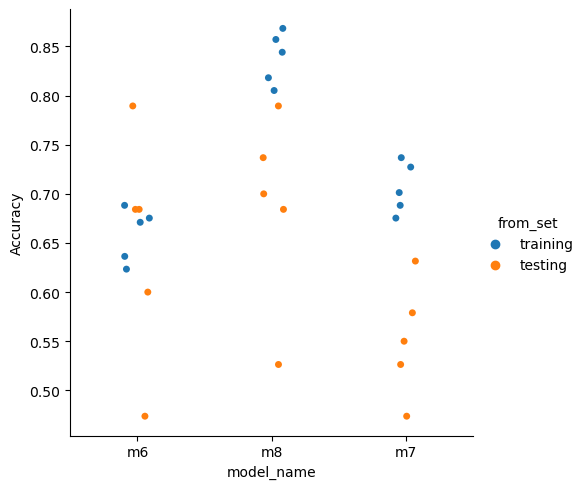

In [80]:
sns.catplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set')

plt.show()

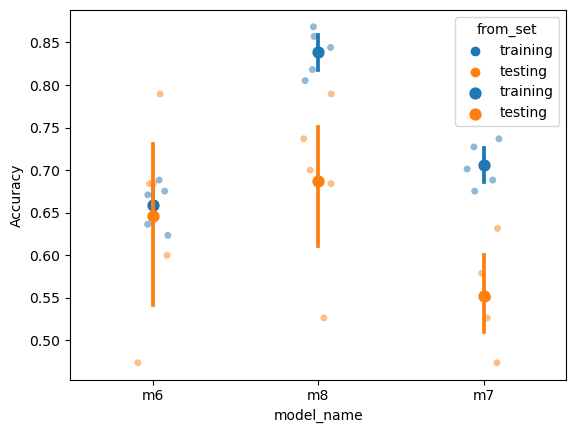

In [81]:
fig, ax = plt.subplots()

sns.stripplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', alpha=0.5, ax=ax)
sns.pointplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', join=False, ax=ax)

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


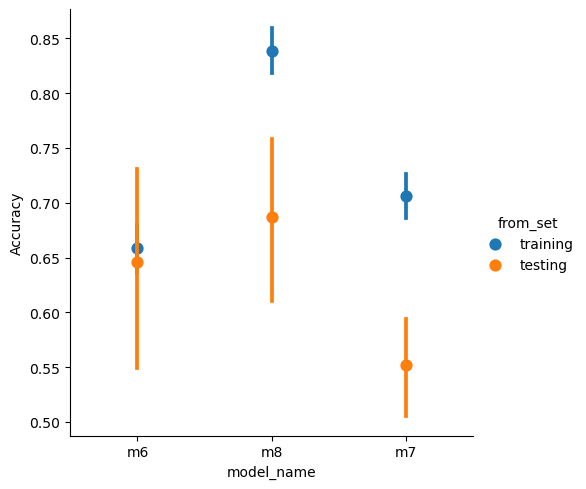

In [82]:
sns.catplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', kind='point', join=False)

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


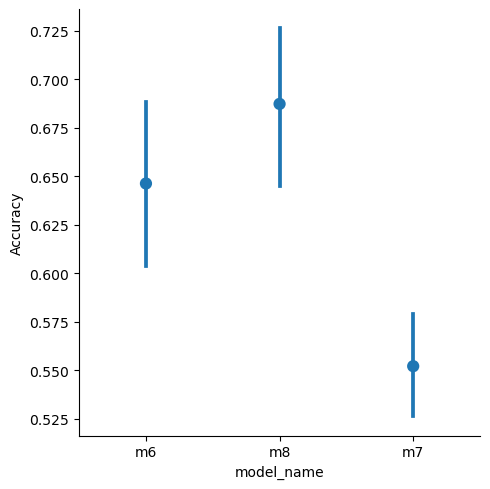

In [83]:
sns.catplot(data = cv_results.loc[ cv_results.from_set == 'testing', :],
            x='model_name', y='Accuracy', kind='point', join=False,
            errorbar=('ci', 68))

plt.show()